# Introduction

Temporal analysis is of essential for understanding complex systems, as it reveals how dynamic patterns and structures emerge over time from local interactions.

This tutorial explores fractal scaling by examining cyclic patterns in ecosystem behavior across various time scales, focusing on Net Ecosystem Exchange (NEE). NEE represents the net carbon flux between an ecosystem and the atmosphere, capturing the balance between carbon uptake through photosynthesis and carbon release through respiration. Thus, it is a key indicator of ecosystem balance.

To investigate potential scaling behavior in NEE, we compare two environmental factors that are likely to influence its dynamics: day versus night, and wet versus dry seasons. Daytime is associated with active photosynthesis, and nighttime with respiration processes. Similarly, wet and dry seasons differ in resource availability, particulary light and water, which may affect the carbon exchange. By comparing these conditions, we aim to explore whether and how the temporal organization of NEE changes under different ecological states.

# Dataset Description

The dataset used in this analysis comes from the FLUXNET2015 collection, specifically the Harvard Forest (US-HA1) site. This site provides high-frequency hourly measurements of ecosystem variables over multiple decades. For this analysis, the main focus was on Net Ecosystem Exchange (NEE), which represents the net carbon flux between the ecosystem and the atmosphere. The variable that was used is called NEE_VUT_REF. Additonally incoming shortwave solar radiation called, SW_IN_F,  was used to distinguish between day and night, while wet vs. dry seasons were defined based on calendar months. The wet seasons contain the months May through September and dry seasons are October through April.

# Preprocessing
The preprocessing steps involve loading the dataset first, followed by parsing the timestamp. Next the previously mentioned variables are extracted and new labels are added to distinguish Daytime and Nighttime and Wet and Dry Season, so the analysis can compare between those different features. 
Addtionally, missing values were removed. This removes the average level of the time series the scaling analysis focuses on the fluctions around the mean and not the mean itself. This results in better interpretable DFA results. 


In [1]:
# load the dataset
import pandas as pd

df = pd.read_csv('FLX_US-Ha1_FLUXNET2015_FULLSET_HR_1991-2012_1-4.csv', skiprows=0)


                     NEE_VUT_REF  SW_IN_F  Daytime  Month Season
TIMESTAMP                                                       
1991-01-01 00:00:00      1.48750      0.0    False      1    Dry
1991-01-01 01:00:00      1.50000      0.0    False      1    Dry
1991-01-01 02:00:00      1.81667      0.0    False      1    Dry
1991-01-01 03:00:00      1.83333      0.0    False      1    Dry
1991-01-01 04:00:00      1.85000      0.0    False      1    Dry


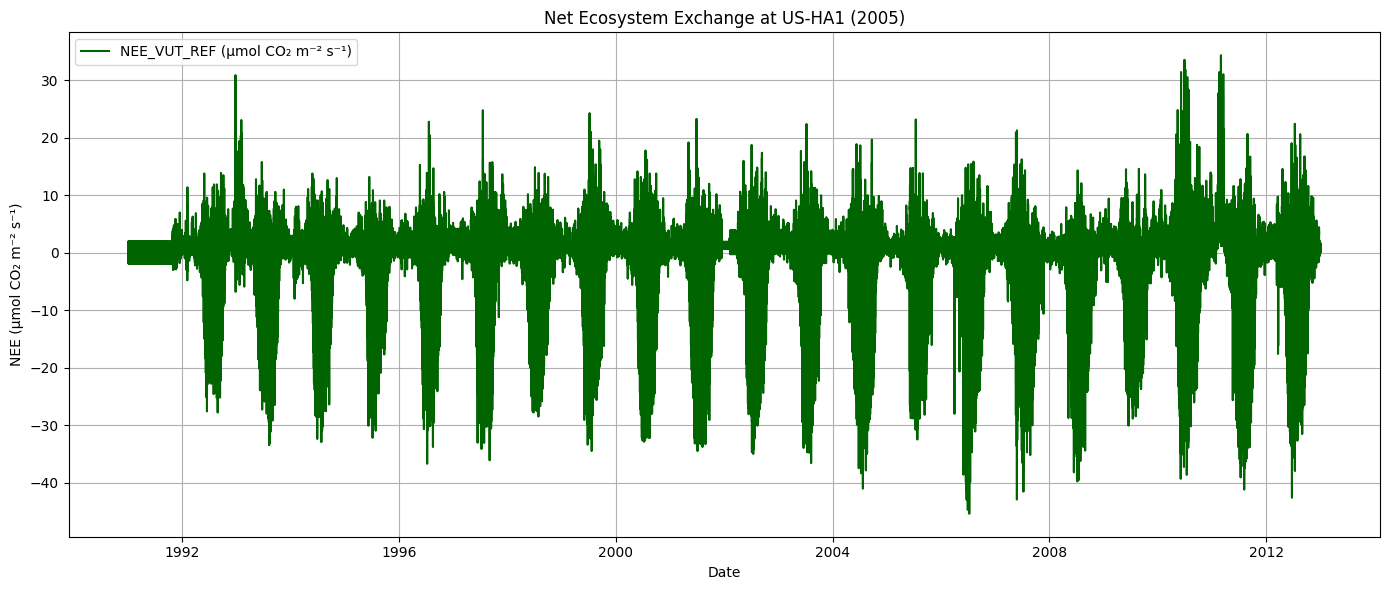

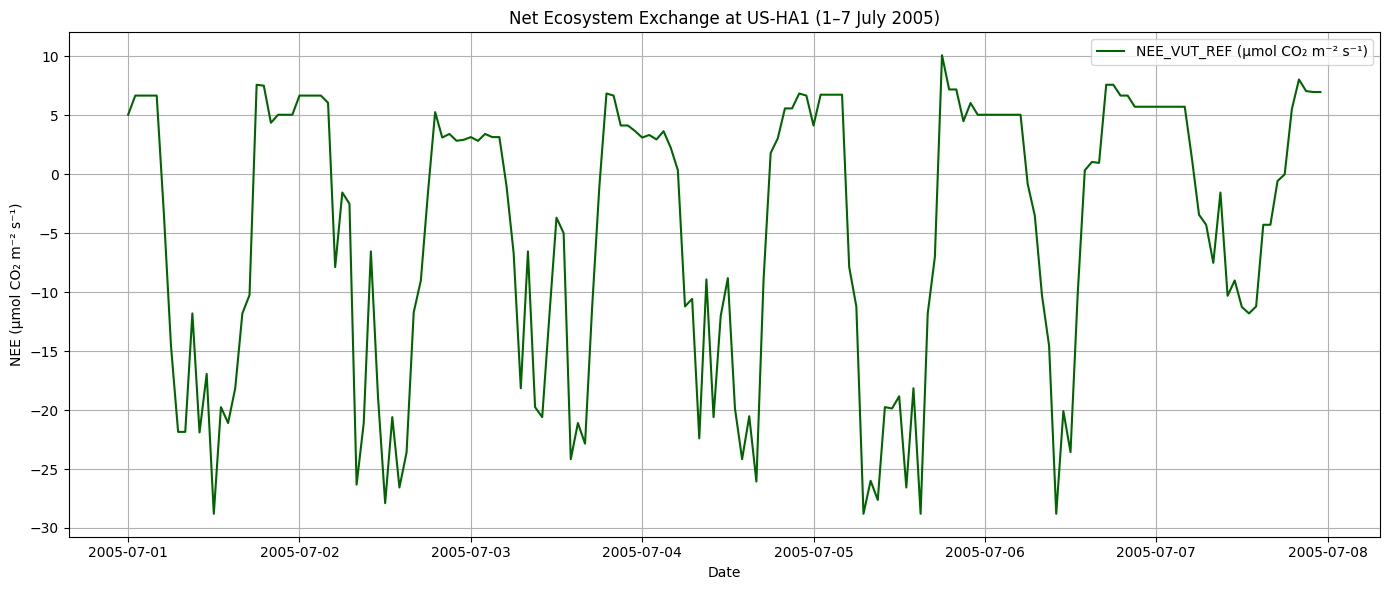

In [3]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# parsing timestamps
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M')
df.set_index('TIMESTAMP', inplace=True)

# choose variable
df_nee = df[['NEE_VUT_REF']]

#clean
df_nee.replace(-9999, pd.NA, inplace=True)
df_nee.dropna(inplace=True)

# day vs night and wet vs dry redistribution
df_nee['SW_IN_F'] = df['SW_IN_F']  
df_nee['Daytime'] = df['SW_IN_F'] > 10
df_nee['Month'] = df_nee.index.month
df_nee['Season'] = df_nee['Month'].apply(lambda x: 'Wet' if x in [5,6,7,8,9] else 'Dry')

print(df_nee.head())

# visualize wet vs dry seasonal patterns
plt.figure(figsize=(14, 6))
plt.plot(df_nee.index, df_nee['NEE_VUT_REF'], label='NEE_VUT_REF (μmol CO₂ m⁻² s⁻¹)', color='darkgreen')
plt.title('Net Ecosystem Exchange at US-HA1 (2005)')
plt.xlabel('Date')
plt.ylabel('NEE (μmol CO₂ m⁻² s⁻¹)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# visualize day vs night patterns
df_week = df_nee['2005-07-01':'2005-07-07']
plt.figure(figsize=(14, 6))
plt.plot(df_week.index, df_week['NEE_VUT_REF'], label='NEE_VUT_REF (μmol CO₂ m⁻² s⁻¹)', color='darkgreen')
plt.title('Net Ecosystem Exchange at US-HA1 (1–7 July 2005)')
plt.xlabel('Date')
plt.ylabel('NEE (μmol CO₂ m⁻² s⁻¹)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The year-plot shows the Net Ecosystem Exchange, showing a clear patterns of peaks that represent a seasonal cycle, summer seasons or wet seasons show large negative values, indicating high carbon uptake by the forest through photosynthesis. In the winter, or dry seasons the values become positive, indicating less uptake. They day plot also shows a patterns matching the fact that there is more photosynthesis during the day then nights.

This variation is consistent with temperate forest flux studies (Barford et al. (2001); Urbanski et al. (2007); Hollinger et al. (2004).

# Detrended Fluctuation Analysis (DFA)

The Net Ecosystem Exchange (NEE) signal shows clear patterns that repeat both daily (from photosynthesis during the day and respiration at night) and seasonally (with more uptake in summer and less in winter). These repeating patterns across different timescales suggest the system has structure at multiple levels, not just at one time scale (Richardson et al., 2006; Barford et al., 2001).

This kind of structure is fractal, meaning that the system behaves in a similar way when you zoom in (hours) or out (months or years). Fractal systems often have long-term memory—past behavior influences future behavior even far apart in time (Goldberger, Peng, & Lipsitz, 2002).

We used Detrended Fluctuation Analysis (DFA) and Multifractal DFA (MF-DFA) to measure this structure. These methods tell us if there are consistent patterns in how the data changes over time, or if it’s just random noise (Kantelhardt et al., 2002; Ihlen, 2012).

Below the DFA function is created that detects whether fluctuations in a time series are random or correlated over different timescales. Morover, this is quantified using the scaling exponent. 

First, the signal is mean-centered. This removes the average so the focus is on the fluctuations. Following, the series is transformed into a random-walk-like profile by calculating the cumulative sum of the signal. This converts the data into non-stationary data so the DFA can look how the fluctuations grow with scale. A pure random walk has a fixed growth scale, so if we observe different scaling exponents, we know our signal has structure, unlike a true random walk.

The loop iterates over inscreasing scales or time windows and calculates the strenghts of the fluctuations for each. The fluctuation is than fitted to a polynomial trend and the fluctuation strenght is calculated using root-mean-squared error, which shows the how much deviations there is from the trend, also called detrending.

By repeating this process for many different window sizes, we can see how the fluctuation size changes with scale. If the system has structure across multiple time scales (e.g., long-range correlations), the fluctuation size will grow in a consistent way as the window size increases. By plotting the results on a log–log scale and fitting a line, we calculate the scaling exponent α, which quantifies the presence and strength of these correlations. The value of a tells us whether the signal behaves like white noise (a ≈ 0.5), has fractal-like memory (0.5 < a < 1), or is strongly trending (a > 1).

Daytime : Scaling component = 0.847
Nighttime : Scaling component = 1.072
Wet Season : Scaling component = 0.522
Dry Season : Scaling component = 0.786


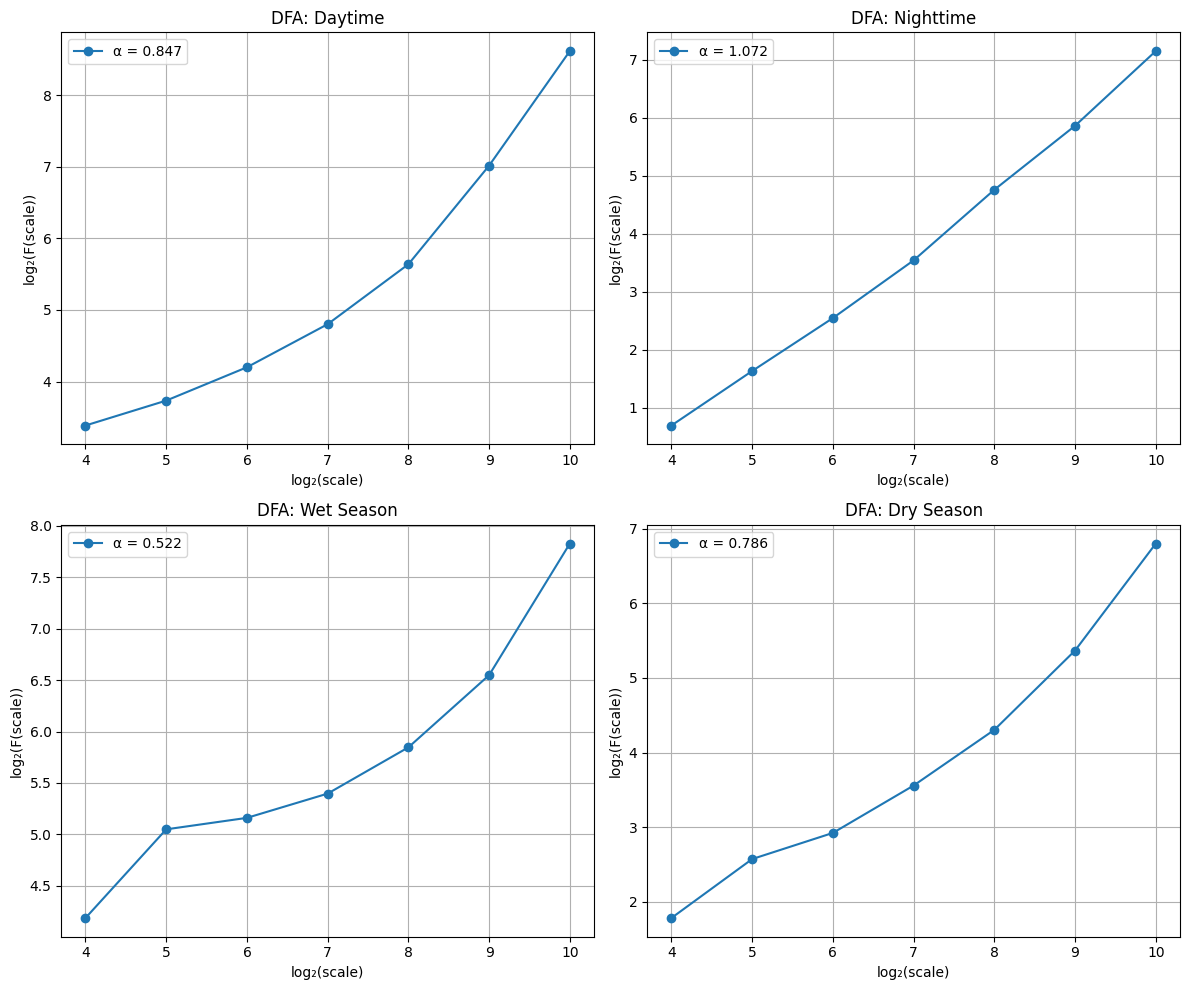

In [9]:
# set up dfa function
import numpy as np

def dfa(signal, scale_min=16, scale_max=1024, scale_ratio=2, order=1):
    # mean-center the signal
    signal = signal - np.mean(signal)

    # integrate (cumulative sum)
    y = np.cumsum(signal)

    scales = []
    fluctuations = []

    s = scale_min
    while s <= scale_max and s < len(y) // 4:
        segments = len(y) // s
        F_nu = []

        for i in range(segments):
            idx_start = i * s
            idx_end = idx_start + s
            segment = y[idx_start:idx_end]
            t = np.arange(s)
            # polynomial detrending
            p = np.polyfit(t, segment, order)
            fit = np.polyval(p, t)
            F_nu.append(np.sqrt(np.mean((segment - fit) ** 2)))

        F = np.sqrt(np.mean(np.array(F_nu) ** 2))
        scales.append(s)
        fluctuations.append(F)

        s = int(s * scale_ratio)

    # linear fit in log-log space
    log_scales = np.log2(scales)
    log_fluct = np.log2(fluctuations)
    alpha = np.polyfit(log_scales, log_fluct, 1)[0]

    return alpha, log_scales, log_fluct

# create subsets
subsets = {
    'Daytime': df_nee[df_nee['Daytime']]['NEE_VUT_REF'],
    'Nighttime': df_nee[~df_nee['Daytime']]['NEE_VUT_REF'],
    'Wet Season': df_nee[df_nee['Season'] == 'Wet']['NEE_VUT_REF'],
    'Dry Season': df_nee[df_nee['Season'] == 'Dry']['NEE_VUT_REF']
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() 

for i, (label, series) in enumerate(subsets.items()):
    series = series.dropna()
    if len(series) > 1500:
        alpha, log_scales, log_fluct = dfa(series.values)
        print(f'{label} : Scaling component = {alpha:.3f}')
        ax = axes[i]
        ax.plot(log_scales, log_fluct, 'o-', label=f'α = {alpha:.3f}')
        ax.set_title(f'DFA: {label}')
        ax.set_xlabel('log₂(scale)')
        ax.set_ylabel('log₂(F(scale))')
        ax.grid(True)
        ax.legend()

plt.tight_layout()
plt.show()

The daytime plot has a scaling component of 0.847, and interestingly the nighttime plot has a higher scaling component of 1.072. These high values indicate fractal behavior, with nighttime having more consistent patterns.

The wet season plot has a scaling component of 0.522, which is significantly lower than the dry season with a component of 0.786. Leading to believe that the dry season is has more structured behavior, while the wet season's patterns may be dominated by external factors or noise. 

# Multifractal DFA 

The MF-DFA function extends the standard DFA by examining how fluctuations behave not just on average, but across a range of moment orders (denoted by q). This allows us to detect multifractal behavior, where different types of fluctuations—large, small, or moderate—scale differently with time. The function begins by mean-centering again and integrating the signal to produce a random-walk-like profile. It then divides the integrated signal into windows of increasing size (scales) and detrends each segment using a polynomial fit, just like in DFA. The fluctuation strength within each segment is computed, but rather than averaging them uniformly, MF-DFA raises the fluctuations to the power of q before averaging—this amplifies or suppresses contributions from large or small deviations, depending on the value of q.

By doing this for multiple q values (typically from -5 to +5), the method captures how scaling behavior differs for small vs. large fluctuations. A linear fit of the fluctuation function in log–log space gives a generalized Hurst exponent H(q) for each q. If H(q) remains constant across q, the signal is monofractal; if it varies, the signal is multifractal—indicating a richer and more heterogeneous temporal structure. The width of the H(q) spectrum is commonly used as a measure of the system’s complexity or adaptability (Kantelhardt et al., 2002).


Daytime: Width of spectrum = 0.1735
Nighttime: Width of spectrum = nan
Wet Season: Width of spectrum = 3.9063
Dry Season: Width of spectrum = 3.9381


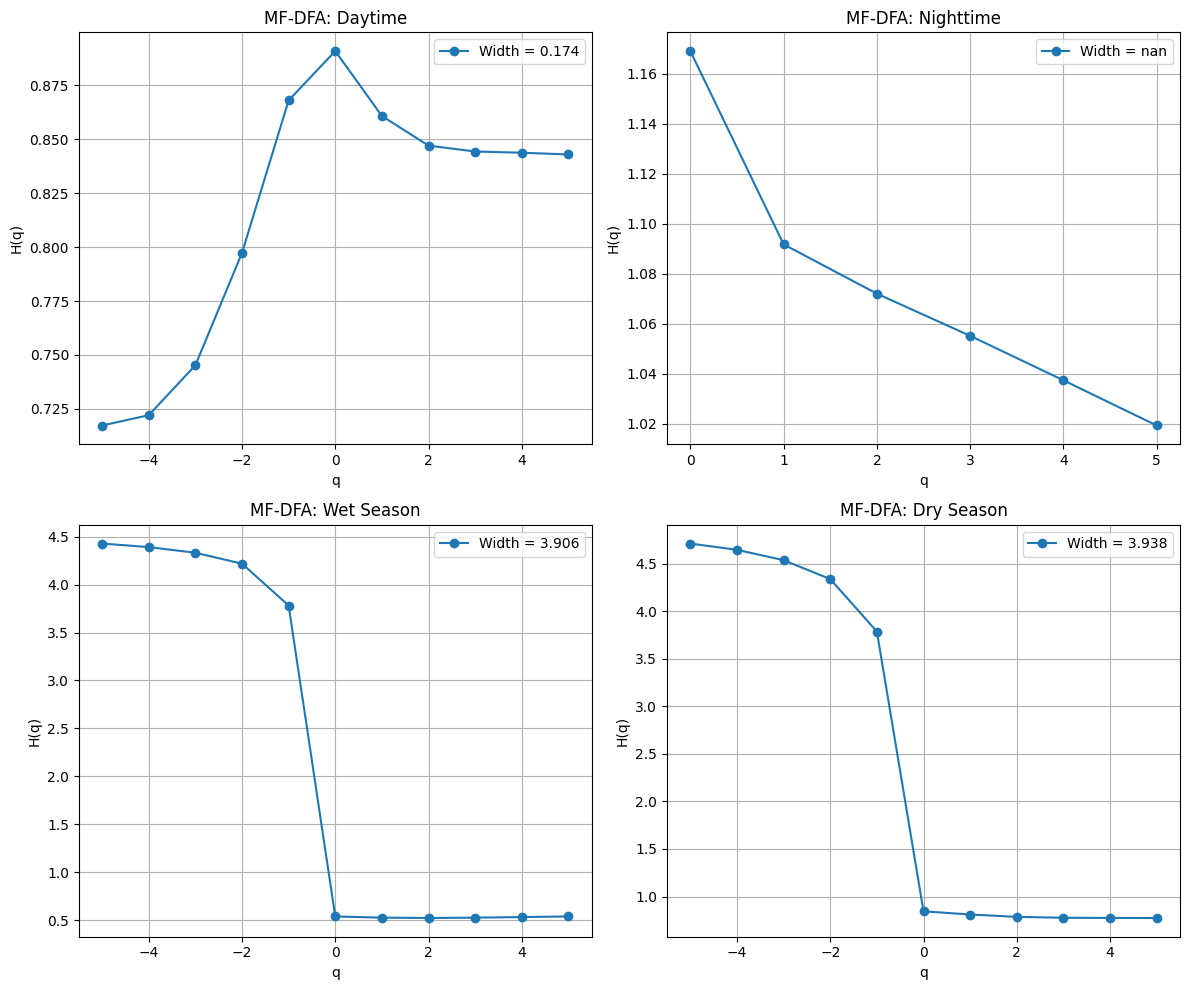

In [5]:
# set up mf-dfa function

warnings.filterwarnings('ignore')

def mfdfa(signal, q_list=np.arange(-5, 6, 1), scale_min=16, scale_max=1024, scale_ratio=2, order=1):
    signal -= np.mean(signal)
    y = np.cumsum(signal)
    N = len(y)
    scales = [int(scale_min * (scale_ratio ** i)) for i in range(int(np.log(scale_max/scale_min)/np.log(scale_ratio))+1)]
    F_q_s = []

    for s in scales:
        Ns = N // s
        F_nu = []
        for i in range(Ns):
            segment = y[i * s:(i + 1) * s]
            t = np.arange(s)
            coeffs = np.polyfit(t, segment, order)
            fit = np.polyval(coeffs, t)
            F_nu.append(np.sqrt(np.mean((segment - fit)**2)))

        F_q = []
        for q in q_list:
            if q == 0:
                F_q.append(np.exp(np.mean(np.log(np.array(F_nu)[np.array(F_nu) > 0]))))
            else:
                F_q.append(np.mean(np.power(F_nu, q))**(1/q))
        F_q_s.append(F_q)

    Hq = [np.polyfit(np.log2(scales), np.log2([row[i] for row in F_q_s]), 1)[0] for i in range(len(q_list))]
    return q_list, Hq


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (label, series) in enumerate(subsets.items()):
    series = series.dropna()
    if len(series) > 1500:
        q, Hq = mfdfa(series.values)
        width = max(Hq) - min(Hq)

        ax = axes[i]
        ax.plot(q, Hq, 'o-', label=f'Width = {width:.3f}')
        ax.set_title(f'MF-DFA: {label}')
        ax.set_xlabel('q')
        ax.set_ylabel('H(q)')
        ax.grid(True)
        ax.legend()

        print(f"{label}: Width of spectrum = {width:.4f}")

plt.tight_layout()
plt.show()


The MF-DFA results show a narrow spectrum width of 0.174 during daytime, indicating monofractal behavior, suggesting that the ecosystem when photosynthesizing is consistently regulated across different fluctuation sizes. However, the nighttime spectrum failed to produce a valid result (NaN), likely due to a lack of variability or structure in the signal. 

The wet and dry seasons both exhibit very wide multifractal spectra, 3.91 and 3.94 respectively, revealing a range of scaling behaviors. This suggests that while the system is more active and potentially noisy during the wet season, and more constrained during the dry season, both periods still maintain a high level of multi-scale organization and complexity in carbon exchange dynamics.

# Compare to Surrogates

To check whether the fractal scaling behavior observed in the original NEE data is valid, we compared each subset to a shuffled surrogate. In the code below, each time series is randomly permuted, which removes its temporal correlations while preserving the overall distribution of values. This allows us to test whether the scaling exponent (a) from DFA reflects true temporal structure or could be explained by random noise alone. By running DFA on both the real and shuffled data and comparing the resulting exponents, we can determine whether the original signal exhibits genuine long-range dependencies. 

Daytime: a_original = 0.847, a_shuffled = 0.506
Nighttime: a_original = 1.072, a_shuffled = 0.487
Wet Season: a_original = 0.522, a_shuffled = 0.504
Dry Season: a_original = 0.786, a_shuffled = 0.510


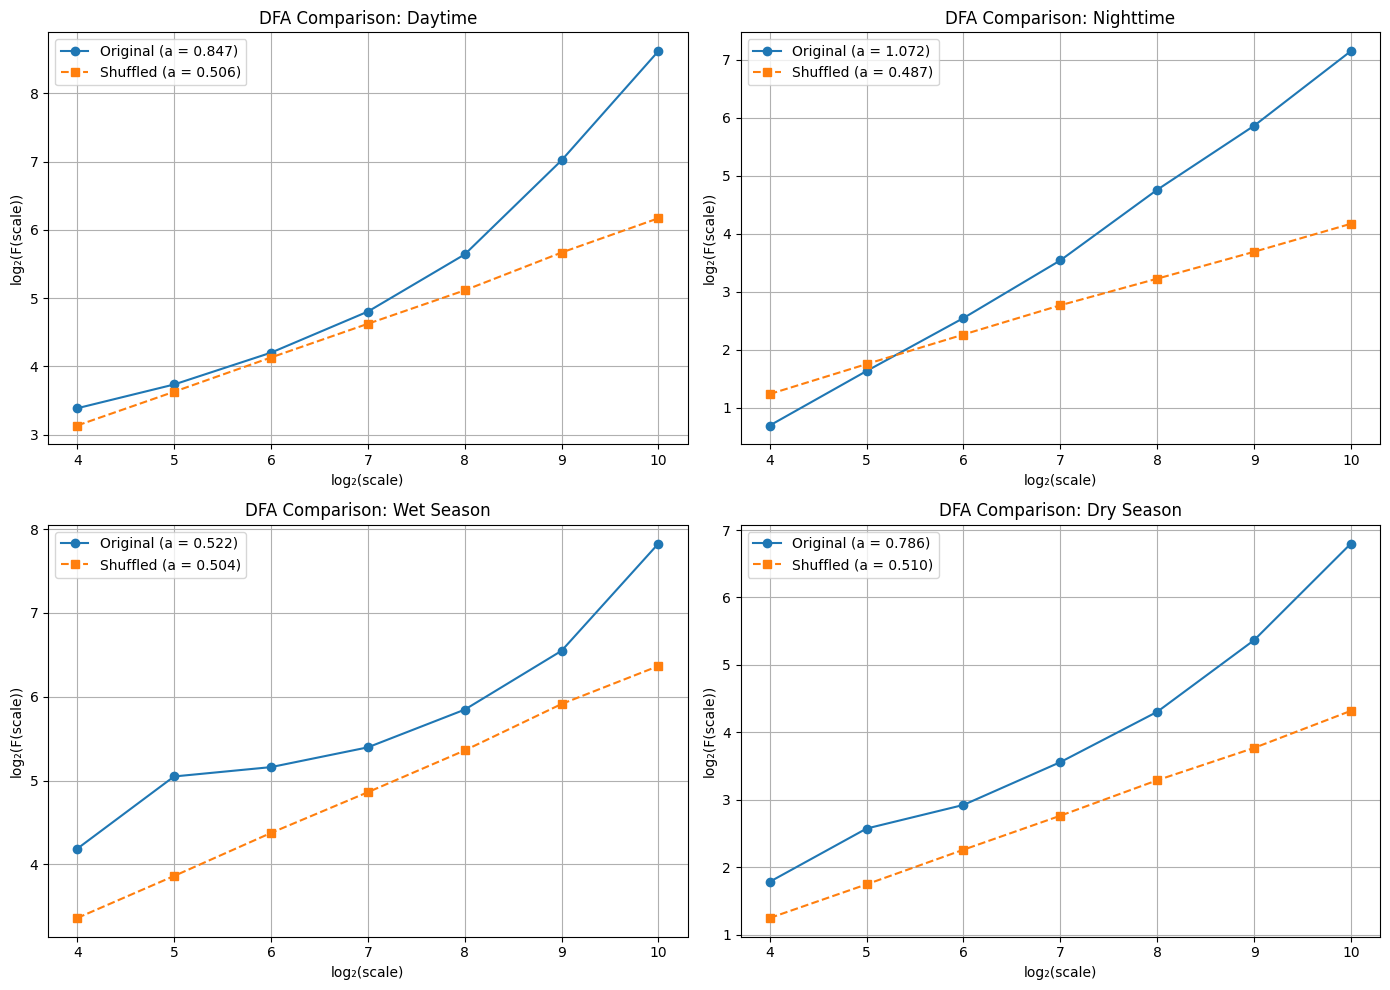

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (label, series) in enumerate(subsets.items()):
    series = series.dropna().values
    if len(series) < 2000:
        print(f"Skipping {label} (not enough data)")
        continue

    # Real signal
    alpha_real, log_s_real, log_f_real = dfa(series)

    # Shuffled surrogate
    np.random.seed(42)
    shuffled = np.random.permutation(series)
    alpha_shuffled, log_s_surr, log_f_surr = dfa(shuffled)

    print(f"{label}: a_original = {alpha_real:.3f}, a_shuffled = {alpha_shuffled:.3f}")

    ax = axes[i]
    ax.plot(log_s_real, log_f_real, 'o-', label=f"Original (a = {alpha_real:.3f})")
    ax.plot(log_s_surr, log_f_surr, 's--', label=f"Shuffled (a = {alpha_shuffled:.3f})")
    ax.set_title(f"DFA Comparison: {label}")
    ax.set_xlabel("log₂(scale)")
    ax.set_ylabel("log₂(F(scale))")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

Daytime (a = 0.847) and nighttime (a = 1.072) both have much higher exponents than their surrogates, indicating strong long-range correlations, especially at night. The dry season also shows clear structure (a = 0.786 vs. 0.510), while the wet season's signal is closer to random (a = 0.522 vs. 0.504). This suggests that ecosystem dynamics are more internally regulated during dry and daytime periods, and more externally driven or variable during the wet season.

# Conclusion
The results suggest that ecosystem carbon exchange shows signs of fractal and multifractal structure, though this varies depending on the environmental conditions. 

DFA indicated that daytime, nighttime and dry season signals have more persistent patterns, while wet season signals appear less consistent, possibly due to greater external variability or noise. 

MF-DFA showed that daytime activity is relatively uniform across scales, whereas both wet and dry seasons display more complex scaling behavior. The comparison with surrogate data supports the idea that some of the observed structure—particularly during daytime and dry periods—is not purely random. This leads to the conclusion that a healthy adaptable ecosystem exhibits fractal and multifractal organization. 

# References

Barford, C. C., Wofsy, S. C., Goulden, M. L., Munger, J. W., Hammond Pyle, E., Urbanski, S. P., ... & Moore, K. (2001).
Factors controlling long- and short-term sequestration of atmospheric CO₂ in a mid-latitude forest. Science, 294(5547), 1688–1691. https://doi.org/10.1126/science.1062962

Goldberger, A. L., Peng, C. K., & Lipsitz, L. A. (2002).
What is physiologic complexity and how does it change with aging and disease? Neurobiology of Aging, 23(1), 23–26. https://doi.org/10.1016/S0197-4580(01)00266-4

Hollinger, D. Y., Aber, J., Dail, B., Davidson, E. A., Lee, J. T., Richardson, A. D., ... & Goltz, S. M. (2004).
Seasonal patterns and environmental control of carbon dioxide and water vapor exchange in an ecotonal boreal forest. Global Change Biology, 10(5), 789–803. https://doi.org/10.1111/j.1529-8817.2003.00767.x

Ihlen, E. A. F. (2012).
Introduction to multifractal detrended fluctuation analysis in Matlab. Frontiers in Physiology, 3, 141. https://doi.org/10.3389/fphys.2012.00141

Kantelhardt, J. W., Zschiegner, S. A., Koscielny-Bunde, E., Havlin, S., Bunde, A., & Stanley, H. E. (2002).
Multifractal detrended fluctuation analysis of nonstationary time series. Physica A: Statistical Mechanics and its Applications, 316(1–4), 87–114. https://doi.org/10.1016/S0378-4371(02)01383-3

Pastorello, G., Trotta, C., Canfora, E. et al. The FLUXNET2015 dataset and the ONEFlux processing pipeline for eddy covariance data. Sci Data 7, 225 (2020). https://doi.org/10.1038/s41597-020-0534-3
[.bib, .ris]

Richardson, A. D., Hollinger, D. Y., Aber, J. D., Ollinger, S. V., & Braswell, B. H. (2006).
Environmental variation is directly responsible for short- but not long-term variation in forest–atmosphere carbon exchange. Global Change Biology, 13(4), 788–803. https://doi.org/10.1111/j.1365-2486.2006.01330.x

Urbanski, S. P., Barford, C., Wofsy, S. C., Kucharik, C., Pyle, E. H., Budney, J., ... & Munger, J. W. (2007).
Factors controlling CO₂ exchange on timescales from hourly to decadal at Harvard Forest. Journal of Geophysical Research: Biogeosciences, 112(G2). https://doi.org/10.1029/2006JG000293